In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer

from datetime import timedelta

import plotly.graph_objs as go
import plotly.offline as pyo

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = '../dasatet_5/BritishMart-morrisons.csv'

bm = pd.read_csv(path)
pd.set_option('display.max_colwidth', None)

In [3]:
# Map sesuai perubahan
unit_mapping = {'kg': 'kg', 'l': 'litre', 'unit': 'ounces', 'm': 'meter'}

bm['unit'] = bm['unit'].replace(unit_mapping)

In [4]:
bm_empty = bm[bm.isna().any(axis=1)]

In [5]:
bm_empty

,nama_toko,harga_pound,harga_per_unit,unit,nama,kategori,brand_sendiri,tanggal


In [6]:
bm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979866 entries, 0 to 979865
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   nama_toko       979866 non-null  object 
 1   harga_pound     979866 non-null  float64
 2   harga_per_unit  979866 non-null  float64
 3   unit            979866 non-null  object 
 4   nama            979866 non-null  object 
 5   kategori        979866 non-null  object 
 6   brand_sendiri   979866 non-null  bool   
 7   tanggal         979866 non-null  object 
dtypes: bool(1), float64(2), object(5)
memory usage: 53.3+ MB


# **Standarization On 'kategori'**

In [7]:
bm[bm['nama'] == 'Alpro Almond Chilled Drink'].head(10)

,nama_toko,harga_pound,harga_per_unit,unit,nama,kategori,brand_sendiri,tanggal
1,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,drinks,False,2021-01-01
16332,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-01-20
36698,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,drinks,False,2021-02-13
60982,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,fresh_food,False,2021-03-13
89688,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,fresh_food,False,2021-04-16
109517,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,fresh_food,False,2021-05-10
125376,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,fresh_food,False,2021-05-28
152528,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,drinks,False,2021-06-29
167763,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,drinks,False,2021-07-17
189559,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,drinks,False,2021-08-12


In [8]:
mode_kategori = bm.groupby('nama')['kategori'].agg(lambda x: x.mode()[0])
bm = pd.merge(bm, mode_kategori, how='left', on='nama', suffixes=('', '_mode'))
bm['kategori'] = bm['kategori_mode']
bm.drop(columns=['kategori_mode'], inplace=True)

In [9]:
bm[bm['nama'] == 'Alpro Almond Chilled Drink'].head(10)

,nama_toko,harga_pound,harga_per_unit,unit,nama,kategori,brand_sendiri,tanggal
1,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-01-01
16332,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-01-20
36698,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-02-13
60982,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-03-13
89688,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-04-16
109517,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-05-10
125376,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-05-28
152528,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-06-29
167763,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-07-17
189559,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-08-12


In [10]:
bm_cleaned = bm.loc[:,['harga_per_unit', 'nama', 'tanggal', 'brand_sendiri', 'unit', 'kategori']]
bm_cleaned['tanggal'] = pd.to_datetime(bm_cleaned['tanggal'])
bm_cleaned.index = bm_cleaned.pop('tanggal')
bm_cleaned.sort_index(inplace=True)

# **Extract Brand Name**

In [11]:
nama_produk = bm_cleaned['nama'].value_counts()

In [12]:
nama_produk.head(10)

nama
Alpro Oat Long Life Drink                   49
Calpol Nasal Drops                          49
Tena Silhouette Pants Black L               49
Vaseline Lip Therapy With Aloe Vera         49
Peach Pure Tea Tree Oil                     49
Always Discreet Boutique Incontinence P…    49
Always Discreet Underwear Bou…              49
Fulfil Chocolate Salted Caram…              49
Calpol Sugar Free Infant Sachets            49
Naturya Flaxseed Mix Berry                  49
Name: count, dtype: int64

In [13]:
from collections import defaultdict, Counter

word_pairs_counts = Counter()
first_word_counts = Counter()

for name in bm_cleaned['nama']:
    name = name.lower()
    words = name.split()
    if len(words) >= 2:
        word_pairs_counts[(words[0], words[1])] += 1
        first_word_counts[words[0]] += 1

word_pairs_grouped = defaultdict(list)
for (first_word, second_word), count in word_pairs_counts.items():
    word_pairs_grouped[first_word].append((second_word, count))

most_common_word_pairs_combined = {
    first_word: sorted(second_words, key=lambda x: x[1], reverse=False)
    for first_word, second_words in word_pairs_grouped.items()
}

df_pair = pd.DataFrame(columns=['First Word', 'Second Word', 'Count', 'First Word Count'])

for first_word, second_words in most_common_word_pairs_combined.items():
    for second_word, count in second_words:
        df_pair = pd.concat([df_pair, pd.DataFrame({
            'First Word': [first_word],
            'Second Word': [second_word],
            'Count': [count],
            'First Word Count': [first_word_counts[first_word]]
        })], ignore_index=True)

In [14]:
df_pair.rename(columns={
    'Count': 'Second Word Count'
}, inplace=True)

In [15]:
df_pair[df_pair['First Word'] == 'nutmeg']

,First Word,Second Word,Second Word Count,First Word Count
1733,nutmeg,gold,2,41933
1734,nutmeg,lilac,2,41933
1735,nutmeg,300tc,2,41933
1736,nutmeg,textured,2,41933
1737,nutmeg,navy,3,41933
...,...,...,...,...
1919,nutmeg,easycare,494,41933
1920,nutmeg,white,509,41933
1921,nutmeg,kids,575,41933
1922,nutmeg,ultra,661,41933


In [16]:
filtered_first = df_pair[df_pair['First Word Count'] > df_pair['Second Word Count']]
first_name_brand = filtered_first[['First Word']].rename(columns={'First Word': 'brand_name'})

filtered_second = df_pair[df_pair['First Word Count'] == df_pair['Second Word Count']]
filtered_second['brand_name'] = filtered_second['First Word'] + ' ' + filtered_second['Second Word']
two_name_brand = filtered_second[['brand_name']]

first_name_brand = first_name_brand.drop_duplicates()
two_name_brand = two_name_brand.drop_duplicates()

brands_name = pd.concat([first_name_brand, two_name_brand], ignore_index=True)

In [17]:
brands_name

,brand_name
0,alpro
1,innocent
2,highland
3,radnor
4,morrisons
...,...
2759,mediterranean magic
2760,montys pineapple
2761,yogi tea
2762,snacksters big


In [18]:
bm_cleaned['brand'] = None
bm_cleaned['nama_lower'] = bm_cleaned['nama'].str.lower()

In [19]:
known_brands_list = brands_name['brand_name'].tolist()

In [20]:
def extract_brand(nama, known_brands):
    nama_words = nama.lower().split()
    for i in range(len(nama_words)):
        for j in range(i+1, len(nama_words)+1):
            candidate = ' '.join(nama_words[i:j])
            if candidate in known_brands:
                return candidate
    return None

bm_cleaned['brand'] = bm_cleaned['nama'].apply(lambda x: extract_brand(x, known_brands_list))
bm_cleaned = bm_cleaned.drop('nama_lower', axis=1)

# **Clean Data By Brand**

In [21]:
avg_harga_per_brand = bm_cleaned.groupby(['tanggal', 'brand'])['harga_per_unit'].mean().reset_index()
avg_harga_per_brand.columns = ['tanggal', 'brand', 'avg_harga_brand']

bm_cleaned_new = bm_cleaned.merge(avg_harga_per_brand, on=['tanggal', 'brand'], how='left')
df_new = bm_cleaned_new.groupby(['unit', 'brand_sendiri', 'tanggal', 'brand']).agg({'avg_harga_brand': 'mean'}).reset_index()

brand_counts = df_new['brand'].value_counts()

brands_to_keep = brand_counts[brand_counts >= 790].index
bm_new = df_new[df_new['brand'].isin(brands_to_keep)]

bm_new['tanggal'] = pd.to_datetime(bm_new['tanggal'])
bm_new.index = bm_new.pop('tanggal')
bm_new.sort_index(inplace=True)

# **Select Brand Example**

In [22]:
bm_new['brand'].value_counts()

brand
morrisons    3351
nutmeg       2228
the          1725
cadbury      1404
john         1254
old          1142
nivea        1119
mr           1090
heinz        1062
oral-b       1007
blue          994
simple        988
dr.           984
gillette      964
market        944
fairy         943
regal         939
colgate       907
ktc           890
st            884
l'oreal       876
alpro         841
good          813
garnier       796
Name: count, dtype: int64

In [23]:
to_keep = ['morrisons', 'nutmeg', 'cadbury', 'nivea', 'heinz', 'oral-b', 'simple', 'gillette', 'fairy', 'regal', 'colgate', 'ktc', "l'oreal", 'alpro', 'garnier']

In [24]:
bm_branded = bm_new[bm_new['brand'] == 'morrisons']

In [25]:
bm_branded.head(3)

,unit,brand_sendiri,brand,avg_harga_brand
tanggal,,,,
2021-01-01,litre,True,morrisons,2.182984
2021-01-01,kg,True,morrisons,2.182984
2021-01-02,kg,True,morrisons,12.498444


In [26]:
bm_branded = bm_branded.reset_index()
bm_branded = bm_branded.drop_duplicates(subset='tanggal')

In [27]:
bm_branded.index = bm_branded.pop('tanggal')
bm_branded.sort_index(inplace=True)

In [28]:
bm_branded.index.duplicated().any()

False

# **Remove Cat Features**

In [29]:
bm_branded = bm_branded.drop('brand', axis=1)
bm_branded = bm_branded.drop('brand_sendiri', axis=1)
bm_branded = bm_branded.drop('unit', axis=1)

# **Fill Empty Dates**

In [30]:
def fill_missing_dates(df, fill_value=np.nan):
    df.index = pd.to_datetime(df.index)
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max())
    df = df.reindex(full_date_range, fill_value=fill_value)
    return df

In [31]:
bm_branded = fill_missing_dates(bm_branded)

# **Imputes All Empty Dates Value With KNN**

In [32]:
imputer = KNNImputer(n_neighbors=5)
bm_branded['avg_harga_brand'] = imputer.fit_transform(bm_branded[['avg_harga_brand']])

In [33]:
bm_branded = bm_branded.rename_axis('tanggal')

In [34]:
bm_branded.head(3)

,avg_harga_brand
tanggal,
2021-01-01,2.182984
2021-01-02,12.498444
2021-01-03,14.490435


# **Exogenous Features Creation**

In [35]:
def create_features(data):
    data['dayofweek']= data.index.dayofweek
    data['quarter']= data.index.quarter
    data['month']= data.index.month
    data['year']= data.index.year
    data['dayofyear']= data.index.dayofyear
    return data

In [36]:
def create_lag_feature(df, value_column, lags):
    df_with_lags = df.copy()
    for lag in lags:
        lag_column = f'lag_{lag}'
        df_with_lags[lag_column] = df_with_lags[value_column].shift(lag)
    df_with_lags = df_with_lags.fillna(0)
    return df_with_lags

In [37]:
def calculate_rolling_means(df, value_column, windows):
    df_sorted = df.sort_index()
    for window in windows:
        rolling_mean_column = f'rolling_mean_{window}'
        df_sorted[rolling_mean_column] = df_sorted[value_column].rolling(window=window).mean().fillna(0)
    return df_sorted

In [38]:
steps = [1, 3, 5, 7]
windows = [3, 5, 7]

bm_branded = create_features(bm_branded)
bm_branded = create_lag_feature(bm_branded, 'avg_harga_brand', steps)
bm_branded = calculate_rolling_means(bm_branded, 'avg_harga_brand', windows)

In [39]:
bm_branded.head(3)

,avg_harga_brand,dayofweek,quarter,month,year,dayofyear,lag_1,lag_3,lag_5,lag_7,rolling_mean_3,rolling_mean_5,rolling_mean_7
tanggal,,,,,,,,,,,,,
2021-01-01,2.182984,4,1,1,2021,1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2021-01-02,12.498444,5,1,1,2021,2,2.182984,0.0,0.0,0.0,0.000000,0.0,0.0
2021-01-03,14.490435,6,1,1,2021,3,12.498444,0.0,0.0,0.0,9.723954,0.0,0.0


# **Stationarity Check**

In [40]:
bm_stationarity_check = bm_branded[['avg_harga_brand']].copy()
bm_stationarity_check.index = pd.to_datetime(bm_stationarity_check.index)
bm_stationarity_check.index.name = 'tanggal'

In [41]:
result = seasonal_decompose(bm_stationarity_check['avg_harga_brand'], period=13)  
trend = result.trend
seasonal = result.seasonal

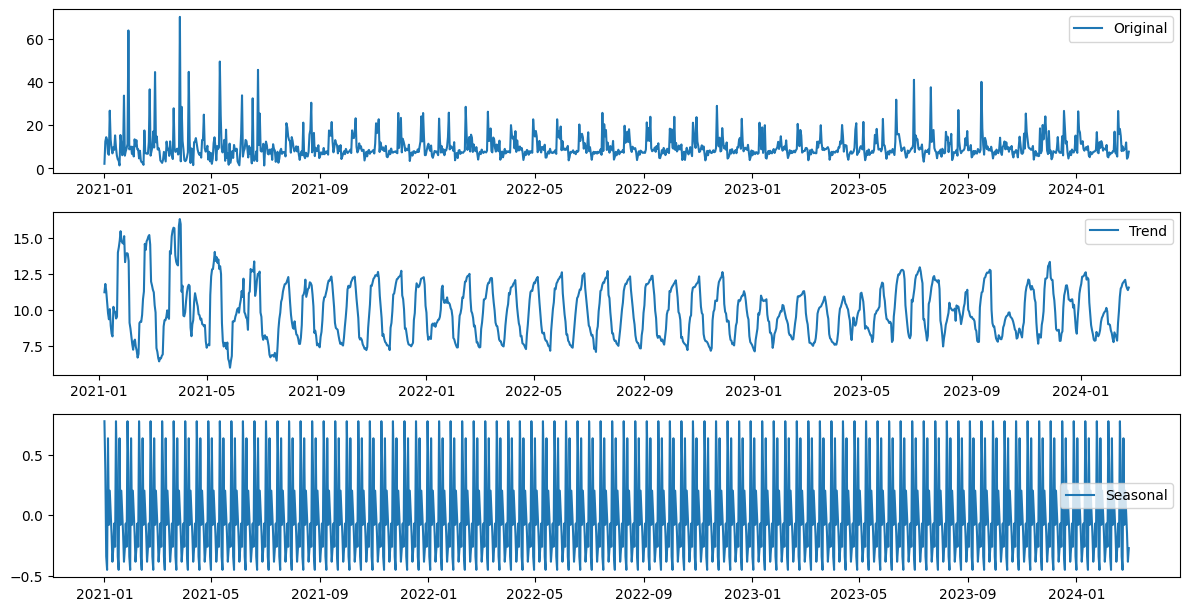

In [42]:
# Plot the components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(bm_stationarity_check.index, bm_stationarity_check['avg_harga_brand'], label='Original')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(bm_stationarity_check.index, trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(bm_stationarity_check.index, seasonal, label='Seasonal')
plt.legend()

plt.tight_layout()
plt.show()

# **ADF Test**

In [43]:
bm_stationarity_check = bm_stationarity_check.sort_index()

def adf_test(series, column_name):
    result = adfuller(series)
    print(f'ADF Statistic for {column_name}: {result[0]}')
    print(f'p-value for {column_name}: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}, {value}')

adf_test(bm_stationarity_check['avg_harga_brand'], 'avg_harga_brand')

ADF Statistic for avg_harga_brand: -14.441717068568986
p-value for avg_harga_brand: 7.340728771184951e-27
Critical Values:
   1%, -3.4361042569951805
   5%, -2.8640808675675826
   10%, -2.568122823703617


# **Split Train (80%) Test (20%)**

In [44]:
bm_branded = bm_branded.sort_index()

test_length = 30

split_index = len(bm_branded) - test_length
train = bm_branded.iloc[:split_index]
test = bm_branded.iloc[split_index:]

print(f"Train set length: {len(train)}")
print(f"Test set length: {len(test)}")

Train set length: 1125
Test set length: 30


In [45]:
trace_train = go.Scatter(x=train.index, y=train['avg_harga_brand'], mode='lines', name='Train')
trace_test = go.Scatter(x=test.index, y=test['avg_harga_brand'], mode='lines', name='Test')

layout = go.Layout(title='Train Test Data', xaxis=dict(title='Date'), yaxis=dict(title='Harga Per Brand'))
fig = go.Figure(data=[trace_train, trace_test], layout=layout)

fig.show()

In [46]:
bm_branded.columns

Index(['avg_harga_brand', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'lag_1', 'lag_3', 'lag_5', 'lag_7', 'rolling_mean_3', 'rolling_mean_5',
       'rolling_mean_7'],
      dtype='object')

In [47]:
X_train = train.drop('avg_harga_brand', axis=1)
y_train = train['avg_harga_brand']

X_test = test.drop('avg_harga_brand', axis=1)
y_test = test['avg_harga_brand']

# **Random Forest Regressor**

In [48]:
rfr = RandomForestRegressor(n_estimators=10000,
                            max_depth=9,
                            min_samples_leaf=3,
                            verbose=1000)
rfr.fit(X_train, y_train)

building tree 1 of 10000
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
building tree 2 of 10000
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
building tree 3 of 10000
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
building tree 4 of 10000
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
building tree 5 of 10000
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
building tree 6 of 10000
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
building tree 7 of 10000
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
building tree 8 of 10000
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
building tree 9 of 10000
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
building tree 10 of 10000
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
building tree 11 of 10000
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.0s
building tree 12 of 10000
[Parallel(n_jobs=1)]: Done

RandomForestRegressor(max_depth=9, min_samples_leaf=3, n_estimators=10000,
                      verbose=1000)

# **Feature Importance**

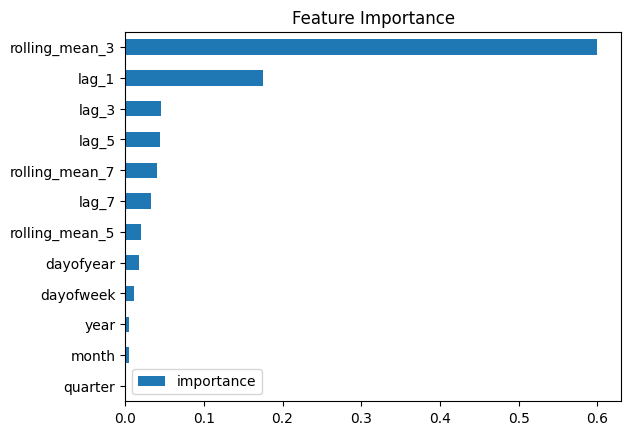

In [49]:
fi = pd.DataFrame(data=rfr.feature_importances_,
                  index=rfr.feature_names_in_,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# **Model Evaluation**

In [50]:
test['forecast'] = rfr.predict(X_test)
bm_branded = bm_branded.merge(test[['forecast']], how='left', left_index=True, right_index=True)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

In [51]:
rfr_forecasted = bm_branded.iloc[split_index:]

In [52]:
test['error'] = np.abs(test['avg_harga_brand'] - test['forecast'])
test['date'] = test.index.date

In [53]:
actual_values = test['avg_harga_brand']
predicted_values = test['forecast']

def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

mape = calculate_mape(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values, predicted_values)

results = pd.DataFrame([{
    'Model': 'RandomForestRegressor',
    'MAE': mae,
    'MAPE': mape,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2
}])

In [54]:
# Worst predicted
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)

date
2024-02-17    7.363592
2024-02-15    6.025088
2024-02-18    5.190089
2024-02-21    3.863355
2024-02-13    3.696323
Name: error, dtype: float64

In [55]:
# Best predicted
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(5)

date
2024-02-10    0.026966
2024-02-02    0.051594
2024-02-23    0.151578
2024-02-09    0.154115
2024-02-20    0.327083
Name: error, dtype: float64

In [56]:
def check_large_prediction_errors(df, actual_col='avg_harga_brand', prediction_col='forecast', threshold=10):
    df['error'] = (df[prediction_col] - df[actual_col]).abs()
    large_errors = df[df['error'] > threshold]
    large_errors = large_errors.drop(columns=['error'])
    return large_errors

rfr_error = check_large_prediction_errors(test[['avg_harga_brand', 'forecast']])

In [57]:
rfr_error

,avg_harga_brand,forecast
tanggal,,


# **Forecasting**

In [58]:
last_date_in_test = test.index.max()
forecast_dates = pd.date_range(last_date_in_test + timedelta(days=1), periods=30, freq='D')
forecast_predictions = rfr.predict(X_test)

bm_forecasted = pd.DataFrame({'date': forecast_dates, 'forecast': forecast_predictions})
bm_forecasted['date'] = pd.to_datetime(bm_forecasted['date'])
bm_forecasted.index = bm_forecasted.pop('date')
bm_forecasted.sort_index(inplace=True)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

In [59]:
filtered_data = bm_branded.iloc[split_index:]

trace1 = go.Scatter(x=filtered_data.index, y=filtered_data['avg_harga_brand'], mode='lines', opacity=1, name='Truth Data')
trace2 = go.Scatter(x=bm_forecasted.index, y=bm_forecasted['forecast'], mode='lines', opacity=1, name='Random Forest Regressor')
layout = go.Layout(title='Forecast', xaxis=dict(title='Date'), yaxis=dict(title='Average Harga Brand'), legend=dict(x=0, y=1))

fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

# **Metrics Evaluation**

In [60]:
results

,Model,MAE,MAPE,MSE,RMSE,R2
0,RandomForestRegressor,1.414748,14.234872,5.379804,2.31944,0.753197


# **Recommendation**

In [61]:
min_index = bm_forecasted['forecast'].idxmin()
max_index = bm_forecasted['forecast'].idxmax()

min_value = bm_forecasted.loc[min_index, 'forecast']
max_value = bm_forecasted.loc[max_index, 'forecast']

print(f'Lowest predicted during {min_index.date()}, with value of: £{min_value.round(2)}')
print(f'Highest predicted during {max_index.date()}, with value of: £{max_value.round(2)}')

Lowest predicted during 2024-03-06, with value of: £5.09
Highest predicted during 2024-03-18, with value of: £19.25
